In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint

2024-10-24 20:46:01.907447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 20:46:01.908050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 20:46:01.911027: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 20:46:01.918472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 20:46:01.931127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# !pip install split_folders

In [3]:
# Скачиваем набор данных из Google Drive в виде архива zip
# !gdown --id 1OEwCqh8Tox2T3C6Q7_XArK286hDGZzeW

In [4]:
# Распаковываем архив с нашим набором данных
# !unzip dataset.zip

In [5]:
# Если вам нужно разделить на train, val и test
import splitfolders

input_folder = "./res/example/content/dataset" #Enter Input Folder
output = "./res/example/content/ready_dataset" #Enter Output Folder

# This library split folders with files (e.g. images) into train, validation and test (dataset) folders.
# Ссылка на документацию по использованию: https://pypi.org/project/split-folders/
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 2290 files [00:00, 3448.29 files/s]


In [6]:
batch_size = 32  # размер мини-пакета
img_height = 224 # высота изображения
img_width = 224  # длина изображения

# Создание обучающего набора данных:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='./res/example/content/ready_dataset/train', # путь к папке с обучающими данными
  label_mode = 'int',       # представление правильных ответов картинок в виде чисел (Label Encoding): 0, 1, 2, 3... (Также можно использовать One-Hot Encoding, для этого напишите categorical) (Если у вас задача бинарной классификации пишите binary)
  color_mode='rgb',         # представление каждой картинки в RGB формате
  batch_size=batch_size,    # параметр, с помощью которого можно регулировать порцию подаваемых примеров (картинок) для сети за одну итерацию обучения
  seed=123,                 # фиксированный seed для случайных процессов (например, перетасовки)
  image_size=(img_height, img_width), # нейронная сеть всегда принимает изображение определённого размера. Поэтому необходимо предварительно поменять размер каждого изображения
  shuffle=True)                       # перетасовка данных, чтобы генерировать данные не в определённом порядке (сначала 1 класс, потом 2 класс), а случайным образом

# Создание валидационного набора данных:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='./res/example/content/ready_dataset/val',  # путь к папке с валидационный данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Отключаем shuffle (перемешивание), чтобы сохранить порядок данных и избежать внесения случайных изменений в процесс оценки модели.

# Создание тестового набора данных:
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory='./res/example/content/ready_dataset/test',  # путь к папке с тестовыми данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Отключаем shuffle (перемешивание), чтобы сохранить порядок данных и избежать внесения случайных изменений в процесс оценки модели.

# здесь вы можете найти документацию по данному генератору: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

Found 1832 files belonging to 7 classes.
Found 229 files belonging to 7 classes.
Found 229 files belonging to 7 classes.


In [7]:
class_names = train_ds.class_names # список классов
num_classes = len(class_names) # количество классов, чтобы указать их в последнем выходном слое
print(class_names)
print(num_classes)

['Airport', 'Beach', 'Center', 'Forest', 'Industrial', 'Playground', 'RailwayStation']
7


2024-10-24 20:46:04.858378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


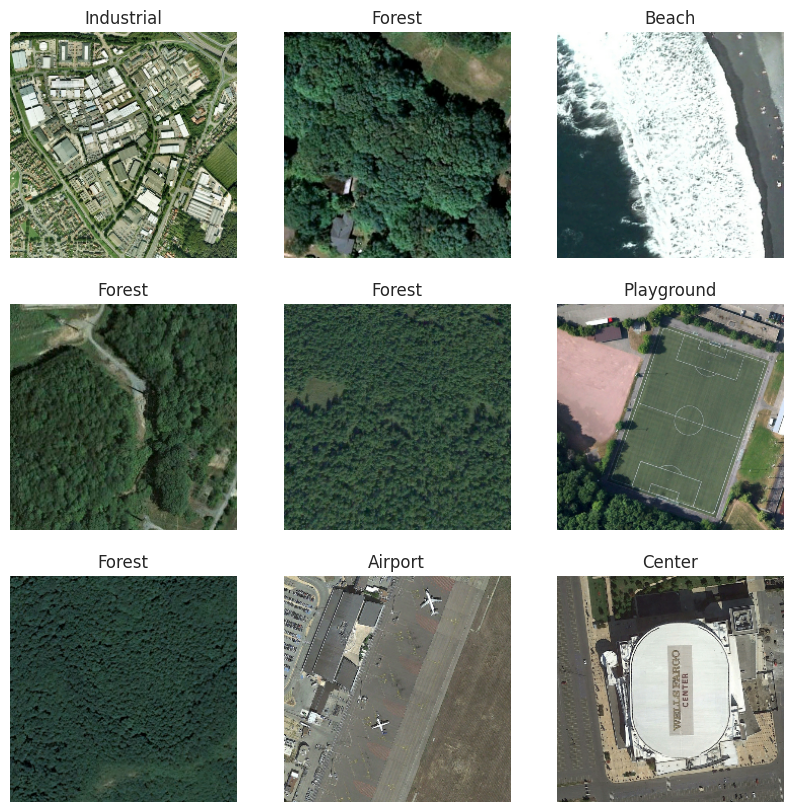

In [8]:
import matplotlib.pyplot as plt

# Визуализация примеров из тренировочного набора данных

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
def createModel(input_shape):
  # Входной слой
  input_layer = Input(shape=input_shape)

  # Здесь можно добавить ваш слой с аугментацией (см. туториал: https://tensorflow.google.cn/tutorials/images/classification?hl=ru#data_augmentation)

  # Нормализация данных от 0 до 1
  normalized_layer = Rescaling(1./255)(input_layer)

  # 1 блок свёртки (Conv + ReLU + MaxPool)
  conv_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same') (normalized_layer)
  pool_1 = MaxPooling2D(2, 2) (conv_1)

  # 2 блок свёртки (Conv + ReLU + MaxPool)
  conv_2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same') (pool_1)
  pool_2 = MaxPooling2D(2, 2) (conv_2)

  # 3 блок свёртки (Conv + ReLU + MaxPool)
  conv_3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same') (pool_2)
  pool_3 = MaxPooling2D(2, 2) (conv_3)

  # 4 блок свёртки (Conv + ReLU + MaxPool)
  conv_4 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same') (pool_3)
  pool_4 = MaxPooling2D(2, 2) (conv_4)

  # Классификационный слой

  # 1. Вариант с промежутночным полностью связанным слоев (количество нейронов выбирайте с умом)
  # flatten_features = Flatten() (pool_4)
  # ffn = Dense(256, activation='relu') (flatten_features)
  # output = Dense(num_classes, activation='softmax') (ffn)

  # 2. Вариант с Global Average Pooling (глобальное усреднение по карте признаков)
  averaged_features = GlobalAveragePooling2D() (pool_4) # усредняет каждый канал выходных признаков, что помогает уменьшить количество параметров и предотвращает переобучение.
  # Полносвязный слой для классификации с функцией активации софтмакс для получения вероятностей классов
  output = Dense(num_classes, activation='softmax') (averaged_features)

  return Model(inputs=input_layer, outputs=output)

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential

# Пример загрузки предварительно обученной модели.

# Загрузка предварительно обученной сети ResNet50 на наборе данных ImageNet (1000 классов различных объектов, более 1 млн. изображений).
# Чтобы использовать эту готвую сеть для вашей задачи, необходимо заменить классификационный слой на новый (поскольку там выходной слой с 1000 нейронами), указав ваше необходимое количество классов.

def create_pretrained_resnet50(input_shape):
  # weights='imagenet' — здесь указано, что модель будет загружена с уже обученными весами из ImageNet.
  # include_top=False — этот параметр означает, что последняя (выходная) часть модели, которая отвечает за классификацию, будет удалена. Мы это делаем, потому что у нас может быть другое количество классов в нашей задаче, и мы хотим заменить её на свою классификационную часть.
  # input_shape=(224, 224, 3) — задаётся форма входного изображения: 224x224 пикселя и 3 канала (RGB).
  resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  model = Sequential()
  model.add(resnet50)                                 # добавляется вся сеть ResNet50 как начальная часть модели, отвечающая за извлечение признаков (features) из изображений.
  model.add(GlobalAveragePooling2D())                 # глобальное усреднение по карте признаков
  model.add(Dense(num_classes, activation='softmax')) # добавляется финальный полносвязный слой, где количество нейронов равно количеству классов в задаче (num_classes)
  return model

In [11]:
def trainModel(train_dataset, val_dataset):
  # Сохранение только наилучшей модели с наименьшей ошибкой на валидации
  save_callback = ModelCheckpoint(filepath='./res/example/best_model.weights.h5', # путь и название файла лучшей модели.
                                  monitor = 'val_loss',             # отслеживать каждую эпоху показать val_loss
                                  save_best_only = True,            # сохранять только самую лучшую модель
                                  save_weights_only=True,           # сохранять только веса модели (не всю модель);
                                  mode = 'min',                     # режим оптимизации min (найти минимальную ошибку)
                                  verbose=1)                        # 1 означает выводить информацию о нахождении и сохранении лучшей модели в процессе обучения, 0 означает не выводить.

  model = createModel((img_height, img_width, 3))                   # создание нашей свёрточной нейронной сети (размерность входа равна (img_height, img_width, 3))

  # model = create_pretrained_resnet50((img_height, img_width, 3))       # создание предварительно обученной свёрточной нейронной сети ResNet50 (для переноса обучения)

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # алгоритм градиентного спуска, минимизирующий функцию ошибки. В нём можно задать скорость обучения (по умолчанию 0.001)
                loss='sparse_categorical_crossentropy',                  # функция ошибки sparse_categorical_crossentropy (поскольку метки представлены целыми числами int) категориальная кроссэнтропия для задачи многоклассовой классификации.
                metrics=['sparse_categorical_accuracy'])                 # метрика accuracy - точность.

  model.summary() # вывод информации о созданной модели

  model.fit(train_dataset,               # указываем обучающий набор данных
            validation_data=val_dataset, # указываем валидационный набор данных
            epochs=30,                   # количество эпох обучения. эпоха представляет собой один полный проход через все данные обучающего набора.
            callbacks=[save_callback]    # используем в процессе обучения созданный ModelCheckpoint
            )
  return model

In [12]:
# Перед обучением обязательно включите GPU: "Среда выполнения" -> "Сменить среду выполнения" -> "T4 GPU"
# Запуск обучения модели
model = trainModel(train_ds, val_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,215 (1.49 MB)

 Trainable params: 390,215 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/58 ━━━━━━━━━━━━━━━━━━━━ 21s 562ms/step - loss: 1.9239 - sparse_categorical_accuracy: 0.1405

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - loss: 1.8647 - sparse_categorical_accuracy: 0.1879
Epoch 1: val_loss improved from inf to 1.38346, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 636ms/step - loss: 1.8629 - sparse_categorical_accuracy: 0.1892 - val_loss: 1.3835 - val_sparse_categorical_accuracy: 0.4279
Epoch 2/30
19/58 ━━━━━━━━━━━━━━━━━━━━ 23s 591ms/step - loss: 1.3520 - sparse_categorical_accuracy: 0.4710

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - loss: 1.3455 - sparse_categorical_accuracy: 0.4730
Epoch 2: val_loss improved from 1.38346 to 1.26494, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 595ms/step - loss: 1.3451 - sparse_categorical_accuracy: 0.4734 - val_loss: 1.2649 - val_sparse_categorical_accuracy: 0.4978
Epoch 3/30
15/58 ━━━━━━━━━━━━━━━━━━━━ 28s 655ms/step - loss: 1.2111 - sparse_categorical_accuracy: 0.5463

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 1.1543 - sparse_categorical_accuracy: 0.5729
Epoch 3: val_loss improved from 1.26494 to 0.97742, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 625ms/step - loss: 1.1535 - sparse_categorical_accuracy: 0.5732 - val_loss: 0.9774 - val_sparse_categorical_accuracy: 0.6114
Epoch 4/30
16/58 ━━━━━━━━━━━━━━━━━━━━ 24s 588ms/step - loss: 0.9509 - sparse_categorical_accuracy: 0.6484

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 0.9676 - sparse_categorical_accuracy: 0.6260
Epoch 4: val_loss improved from 0.97742 to 0.87635, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - loss: 0.9679 - sparse_categorical_accuracy: 0.6258 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.6288
Epoch 5/30
37/58 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step - loss: 0.8955 - sparse_categorical_accuracy: 0.6539

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 0.9272 - sparse_categorical_accuracy: 0.6447
Epoch 5: val_loss improved from 0.87635 to 0.86938, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 612ms/step - loss: 0.9280 - sparse_categorical_accuracy: 0.6445 - val_loss: 0.8694 - val_sparse_categorical_accuracy: 0.6594
Epoch 6/30
30/58 ━━━━━━━━━━━━━━━━━━━━ 17s 633ms/step - loss: 0.8428 - sparse_categorical_accuracy: 0.6603

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - loss: 0.8613 - sparse_categorical_accuracy: 0.6564
Epoch 6: val_loss improved from 0.86938 to 0.84521, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 625ms/step - loss: 0.8616 - sparse_categorical_accuracy: 0.6565 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.6550
Epoch 7/30
15/58 ━━━━━━━━━━━━━━━━━━━━ 24s 579ms/step - loss: 0.8334 - sparse_categorical_accuracy: 0.6883

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 0.8595 - sparse_categorical_accuracy: 0.6796
Epoch 7: val_loss improved from 0.84521 to 0.82038, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 583ms/step - loss: 0.8596 - sparse_categorical_accuracy: 0.6795 - val_loss: 0.8204 - val_sparse_categorical_accuracy: 0.6812
Epoch 8/30
28/58 ━━━━━━━━━━━━━━━━━━━━ 16s 556ms/step - loss: 0.8284 - sparse_categorical_accuracy: 0.6610

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.8056 - sparse_categorical_accuracy: 0.6789
Epoch 8: val_loss did not improve from 0.82038
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 579ms/step - loss: 0.8055 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.9590 - val_sparse_categorical_accuracy: 0.5721
Epoch 9/30
17/58 ━━━━━━━━━━━━━━━━━━━━ 22s 548ms/step - loss: 0.8857 - sparse_categorical_accuracy: 0.6404

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 0.8468 - sparse_categorical_accuracy: 0.6627
Epoch 9: val_loss improved from 0.82038 to 0.64626, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step - loss: 0.8458 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.6463 - val_sparse_categorical_accuracy: 0.7729
Epoch 10/30
22/58 ━━━━━━━━━━━━━━━━━━━━ 20s 558ms/step - loss: 0.8529 - sparse_categorical_accuracy: 0.6952

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.8328 - sparse_categorical_accuracy: 0.6967
Epoch 10: val_loss did not improve from 0.64626
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 600ms/step - loss: 0.8319 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.7511
Epoch 11/30
13/58 ━━━━━━━━━━━━━━━━━━━━ 25s 566ms/step - loss: 0.7595 - sparse_categorical_accuracy: 0.7102

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 0.7615 - sparse_categorical_accuracy: 0.7125
Epoch 11: val_loss did not improve from 0.64626
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - loss: 0.7612 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.7418 - val_sparse_categorical_accuracy: 0.7249
Epoch 12/30
14/58 ━━━━━━━━━━━━━━━━━━━━ 25s 575ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.7432

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 0.6975 - sparse_categorical_accuracy: 0.7357
Epoch 12: val_loss improved from 0.64626 to 0.57775, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.7360 - val_loss: 0.5777 - val_sparse_categorical_accuracy: 0.7686
Epoch 13/30
21/58 ━━━━━━━━━━━━━━━━━━━━ 22s 597ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.7510

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.7621
Epoch 13: val_loss improved from 0.57775 to 0.49386, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 593ms/step - loss: 0.6210 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.4939 - val_sparse_categorical_accuracy: 0.8122
Epoch 14/30
16/58 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - loss: 0.5491 - sparse_categorical_accuracy: 0.8026

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 0.5862 - sparse_categorical_accuracy: 0.7788
Epoch 14: val_loss did not improve from 0.49386
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 597ms/step - loss: 0.5865 - sparse_categorical_accuracy: 0.7786 - val_loss: 0.5096 - val_sparse_categorical_accuracy: 0.7948
Epoch 15/30
14/58 ━━━━━━━━━━━━━━━━━━━━ 24s 550ms/step - loss: 0.6062 - sparse_categorical_accuracy: 0.7835

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7883
Epoch 15: val_loss improved from 0.49386 to 0.45925, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 567ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.4592 - val_sparse_categorical_accuracy: 0.8166
Epoch 16/30
15/58 ━━━━━━━━━━━━━━━━━━━━ 26s 609ms/step - loss: 0.5303 - sparse_categorical_accuracy: 0.7837

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.7897
Epoch 16: val_loss did not improve from 0.45925
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 605ms/step - loss: 0.5539 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.7860
Epoch 17/30
13/58 ━━━━━━━━━━━━━━━━━━━━ 25s 568ms/step - loss: 0.5255 - sparse_categorical_accuracy: 0.7969

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 0.5336 - sparse_categorical_accuracy: 0.7988
Epoch 17: val_loss did not improve from 0.45925
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 579ms/step - loss: 0.5335 - sparse_categorical_accuracy: 0.7988 - val_loss: 0.4886 - val_sparse_categorical_accuracy: 0.8079
Epoch 18/30
12/58 ━━━━━━━━━━━━━━━━━━━━ 25s 555ms/step - loss: 0.5194 - sparse_categorical_accuracy: 0.7994

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.5307 - sparse_categorical_accuracy: 0.7943
Epoch 18: val_loss improved from 0.45925 to 0.42159, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 575ms/step - loss: 0.5307 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.4216 - val_sparse_categorical_accuracy: 0.8210
Epoch 19/30
19/58 ━━━━━━━━━━━━━━━━━━━━ 22s 588ms/step - loss: 0.5174 - sparse_categorical_accuracy: 0.8262

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - loss: 0.5206 - sparse_categorical_accuracy: 0.8180
Epoch 19: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 593ms/step - loss: 0.5204 - sparse_categorical_accuracy: 0.8181 - val_loss: 0.4418 - val_sparse_categorical_accuracy: 0.8166
Epoch 20/30
17/58 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - loss: 0.4404 - sparse_categorical_accuracy: 0.8413

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.4700 - sparse_categorical_accuracy: 0.8287
Epoch 20: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - loss: 0.4704 - sparse_categorical_accuracy: 0.8285 - val_loss: 0.6029 - val_sparse_categorical_accuracy: 0.7598
Epoch 21/30
21/58 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step - loss: 0.5648 - sparse_categorical_accuracy: 0.7905

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 0.5211 - sparse_categorical_accuracy: 0.8052
Epoch 21: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 573ms/step - loss: 0.5207 - sparse_categorical_accuracy: 0.8052 - val_loss: 0.4745 - val_sparse_categorical_accuracy: 0.8122
Epoch 22/30
32/58 ━━━━━━━━━━━━━━━━━━━━ 14s 553ms/step - loss: 0.5155 - sparse_categorical_accuracy: 0.8016

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 0.5127 - sparse_categorical_accuracy: 0.8060
Epoch 22: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 568ms/step - loss: 0.5123 - sparse_categorical_accuracy: 0.8062 - val_loss: 0.4740 - val_sparse_categorical_accuracy: 0.7991
Epoch 23/30
18/58 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - loss: 0.4700 - sparse_categorical_accuracy: 0.8229

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 0.4631 - sparse_categorical_accuracy: 0.8311
Epoch 23: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 573ms/step - loss: 0.4630 - sparse_categorical_accuracy: 0.8311 - val_loss: 0.6216 - val_sparse_categorical_accuracy: 0.7380
Epoch 24/30
13/58 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - loss: 0.4899 - sparse_categorical_accuracy: 0.7898

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 0.4694 - sparse_categorical_accuracy: 0.8161
Epoch 24: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 571ms/step - loss: 0.4692 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.4965 - val_sparse_categorical_accuracy: 0.8253
Epoch 25/30
18/58 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.8090

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.8293
Epoch 25: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 575ms/step - loss: 0.4585 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.4773 - val_sparse_categorical_accuracy: 0.8122
Epoch 26/30
18/58 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step - loss: 0.3950 - sparse_categorical_accuracy: 0.8531

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 0.4065 - sparse_categorical_accuracy: 0.8519
Epoch 26: val_loss did not improve from 0.42159
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 573ms/step - loss: 0.4066 - sparse_categorical_accuracy: 0.8519 - val_loss: 0.4312 - val_sparse_categorical_accuracy: 0.7991
Epoch 27/30
19/58 ━━━━━━━━━━━━━━━━━━━━ 21s 561ms/step - loss: 0.4104 - sparse_categorical_accuracy: 0.8527

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 0.4044 - sparse_categorical_accuracy: 0.8539
Epoch 27: val_loss improved from 0.42159 to 0.40661, saving model to ./res/example/best_model.weights.h5
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 571ms/step - loss: 0.4043 - sparse_categorical_accuracy: 0.8539 - val_loss: 0.4066 - val_sparse_categorical_accuracy: 0.8384
Epoch 28/30
13/58 ━━━━━━━━━━━━━━━━━━━━ 25s 576ms/step - loss: 0.3491 - sparse_categorical_accuracy: 0.8673

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - loss: 0.3633 - sparse_categorical_accuracy: 0.8628
Epoch 28: val_loss did not improve from 0.40661
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 603ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.8628 - val_loss: 0.4285 - val_sparse_categorical_accuracy: 0.8341
Epoch 29/30
15/58 ━━━━━━━━━━━━━━━━━━━━ 23s 555ms/step - loss: 0.4015 - sparse_categorical_accuracy: 0.8267

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 0.4003 - sparse_categorical_accuracy: 0.8461
Epoch 29: val_loss did not improve from 0.40661
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 575ms/step - loss: 0.4000 - sparse_categorical_accuracy: 0.8463 - val_loss: 0.4311 - val_sparse_categorical_accuracy: 0.8122
Epoch 30/30
13/58 ━━━━━━━━━━━━━━━━━━━━ 25s 563ms/step - loss: 0.3727 - sparse_categorical_accuracy: 0.8489

Corrupt JPEG data: premature end of data segment


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.4098 - sparse_categorical_accuracy: 0.8427
Epoch 30: val_loss did not improve from 0.40661
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 574ms/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8427 - val_loss: 0.4677 - val_sparse_categorical_accuracy: 0.8253


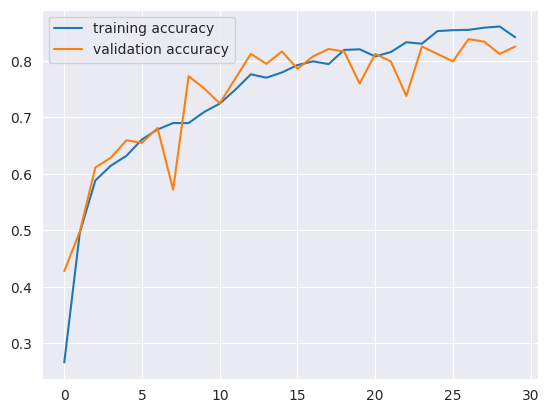

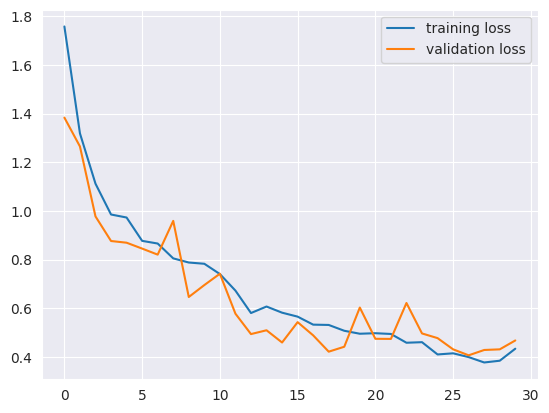

In [13]:
# Вывод графиков обучения

plt.figure()
plt.plot(model.history.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(model.history.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [15]:
# Загрузка весов самой лучшей модели с самой маленькой ошибкой
model.load_weights('./res/example/best_model.weights.h5')

In [16]:
# Тестирование на тестовых данных
loss, accuracy = model.evaluate(test_ds)
print("Точность модели CNN: " + str(accuracy))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.4218 - sparse_categorical_accuracy: 0.8503
Точность модели CNN: 0.8253275156021118


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Предсказанный ответ: Playground
Правильный ответ: Playground


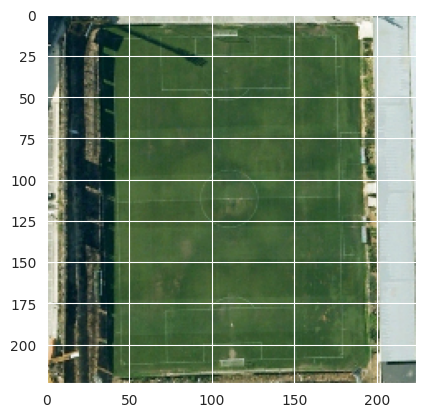

In [19]:
# Здесь мы берём каждый раз случайное изображение из test_ds и предсказываем для него класс.
# Эту ячейку можно запускать много раз и смотреть результаты классификации для разных картинок.

for image_batch, label_batch in test_ds.shuffle(buffer_size=len(list(test_ds))).take(1):
    # Выбираем случайный индекс изображения из мини-пакета
    random_index = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(image_batch)[0], dtype=tf.int32)
    # Извлекаем случайное изображение и метку
    image = image_batch[random_index]
    label = label_batch[random_index]
    predictions = model.predict(tf.expand_dims(image, axis=0))
    # Get the predicted class label
    predicted_class_index = tf.argmax(predictions, axis=-1)
    predicted_class_label = test_ds.class_names[predicted_class_index[0]]
    # Print the predicted class label and true label
    print("Предсказанный ответ:", predicted_class_label)
    print("Правильный ответ:", test_ds.class_names[label])
    plt.imshow(image.numpy().astype("uint8"))

In [18]:
# Вывод classification report на тестовых данных
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
print("Classification Report for Our Convolutional Neural Network")
print(classification_report(true_labels, predicted_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Classification Report for Our Convolutional Neural Network
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        36
           1       0.97      0.97      0.97        40
           2       0.70      0.62      0.65        26
           3       1.00      1.00      1.00        25
           4       0.70      0.82      0.75        39
           5       0.92      0.97      0.95        37
           6       0.92      0.42      0.58        26

    accuracy                           0.83       229
   macro avg       0.84      0.81      0.81       229
weighted avg       0.84      0.83      0.82       229



2024-10-24 21:13:57.812037: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
# Если нужно использовать ранее обученную вашу модель

# 1. Инициализируйте вашу модель
model = createModel((img_height, img_width, 3))

# 2 Скомпилируйте вашу модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# 3. Загрузите веса в вашу модель
model.load_weights('./res/example/best_model_weights.h5')

# 4. Если хотите оценить точность на своих данных
# model.evaluate(test_ds)

# 5. Если хотите протестировать на конкретном примере
# predictions = loaded_model.predict(x_test)

# 6. Если хотите обучить или дообучить вашу модель, просто вызываете метод fit
# model.fit(...)

ValueError: Expected `metrics` argument to be a list, tuple, or dict. Received instead: metrics=accuracy of type <class 'str'>